# Data preparation for Nanostring

In [2]:
!pip install scikit-misc

import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

%load_ext autoreload
%autoreload 2
%load_ext lab_black

sc.logging.print_header()

/opt/homebrew/Caskroom/miniforge/base/envs/squidpy_3_9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


## Download the data, unpack and load to anndata

Download the data from [Nanostring FFPE Dataset](https://nanostring.com/products/cosmx-spatial-molecular-imager/ffpe-dataset/). Unpack the `.tar.gz` file.
Load the unpacked dataset into an [`anndata.AnnData`](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html) object.

In [2]:
!mkdir tutorial_data
!mkdir tutorial_data/nanostring_data
!wget -P tutorial_data/nanostring_data https://nanostring-public-share.s3.us-west-2.amazonaws.com/SMI-Compressed/Lung5_Rep2/Lung5_Rep2+SMI+Flat+data.tar.gz
!tar -xzf tutorial_data/nanostring_data/Lung5_Rep2+SMI+Flat+data.tar.gz -C tutorial_data/nanostring_data/.


nanostring_dir = Path(".") / "tutorial_data" / "nanostring_data"


sample_dir = nanostring_dir / "Lung5_Rep2" / "Lung5_Rep2-Flat_files_and_images"


adata = sq.read.nanostring(
    path=sample_dir,
    counts_file="Lung5_Rep2_exprMat_file.csv",
    meta_file="Lung5_Rep2_metadata_file.csv",
    fov_file="Lung5_Rep2_fov_positions_file.csv",
)
adata.uns["spatial"].keys()

dict_keys(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '4', '5', '6', '7', '8', '9'])

## Make the variable names unique, filter the mitochondrial genes

Make the variable names unique using the method [`anndata.var_names_make_unique`](https://anndata.readthedocs.io/en/refpaths/anndata.AnnData.var_names_make_unique.html).
Obtain the mitochondrial genes using their names prefixed with "mt-".
Calculate the quality control metrics on the [`anndata.AnnData`](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html) using [`scanpy.pp.calculate_qc_metrics`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html).

In [4]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

## Plot the 'total_counts' and 'n_genes_by_counts' to filter the cells and genes

Plot the "total_counts" and "n_genes_by_counts" from [`anndata.obs`](https://anndata.readthedocs.io/en/refpaths/anndata.AnnData.obs.html).
The first subplot shows `adata.obs["total_counts"]`, the second `adata.obs["total_counts"]` less than 10000.
The third subplot displays `adata.obs["n_genes_by_counts"]` while the fourth displays the `adata.obs["n_genes_by_counts"]` less than 4000.

/opt/homebrew/Caskroom/miniforge/base/envs/squidpy_3_9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

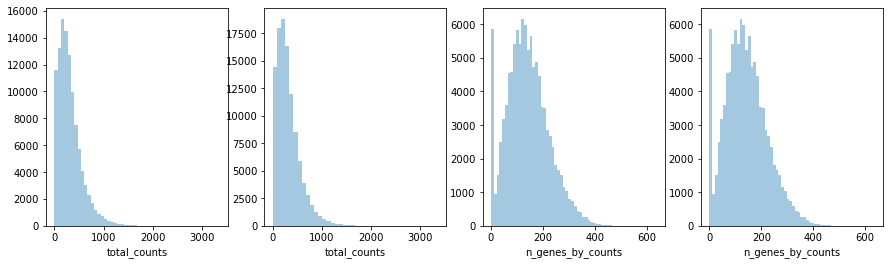

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)
sns.distplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.distplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    bins=60,
    ax=axs[2],
)
sns.distplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

Filter the cells based on the minimum number of counts required using [`scanpy.pp.filter_cells`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.filter_cells.html). Filter the genes based on the minimum number of cells required with [`scanpy.pp.filter_genes`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.filter_genes.html). The parameters for the both were specified based on the plots above. They were set to filter out nearly 10% of the cells and genes with minimum counts and minimum cells respectively.

In [6]:
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=400)

## Annotate the genes, normalize counts per cell

Annotate the highly variable genes based on the count data by using [`scanpy.pp.highly_variable_genes`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html) with `flavor="seurat_v3"`. Normalize counts per cell using [`scanpy.pp.normalize_total`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.normalize_total.html).

Logarithmize, do principle component analysis, compute a neighborhood graph of the observations using [`scanpy.pp.log1p`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.log1p.html), [`scanpy.pp.pca`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.pca.html) and [`scanpy.pp.neighbors`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.neighbors.html) respectively.

Use [`scanpy.tl.umap`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.umap.html) to embed the neighborhood graph that indicates the topology of the data and cluster the cells into subgroups employing [`scanpy.tl.leiden`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.leiden.html).

In [7]:
adata.raw = adata
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.7)

## Plot UMAP and rank genes

Subplot with scatter plot in UMAP(Uniform Manifold Approximation and Projection) basis. The topology of the data was represented by the embedded points. These embedded points were colored, respectively, according to the total counts, number of genes by counts, leiden clustered subgroups and fields of view in each of the subplots. This gives us some idea of what the data looks like.

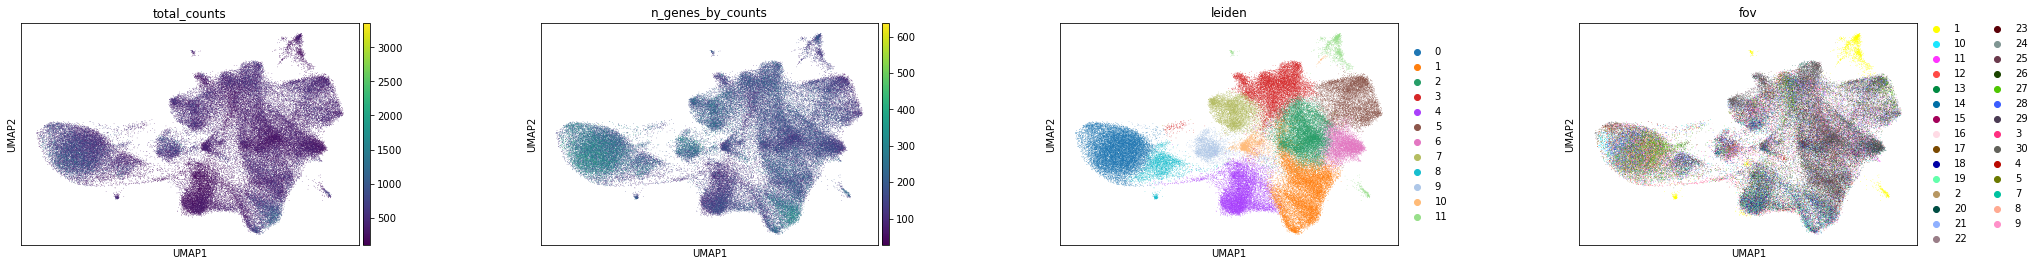

In [8]:
sc.pl.umap(
    adata, color=["total_counts", "n_genes_by_counts", "leiden", "fov"], wspace=0.4
)

Rank the genes for characterizing groups with [`scanpy.tl.rank_genes_groups`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html), based on the Leiden grouping. This returns the [`anndata.AnnData`](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html) object with `anndata.uns["rank_genes_groups"]` with ['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'] as keys.

In [9]:
sc.tl.rank_genes_groups(adata, groupby="leiden")
adata.uns["rank_genes_groups"].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

Plot the ranking of the genes from above using [`scanpy.pl.rank_genes_groups`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.rank_genes_groups.html#scanpy.pl.rank_genes_groups). Each of the subplots represents the gene ranking for each Leiden clustered group. Top 20 genes are plotted by default. This can be changed by specifying the parameter `n_genes`.

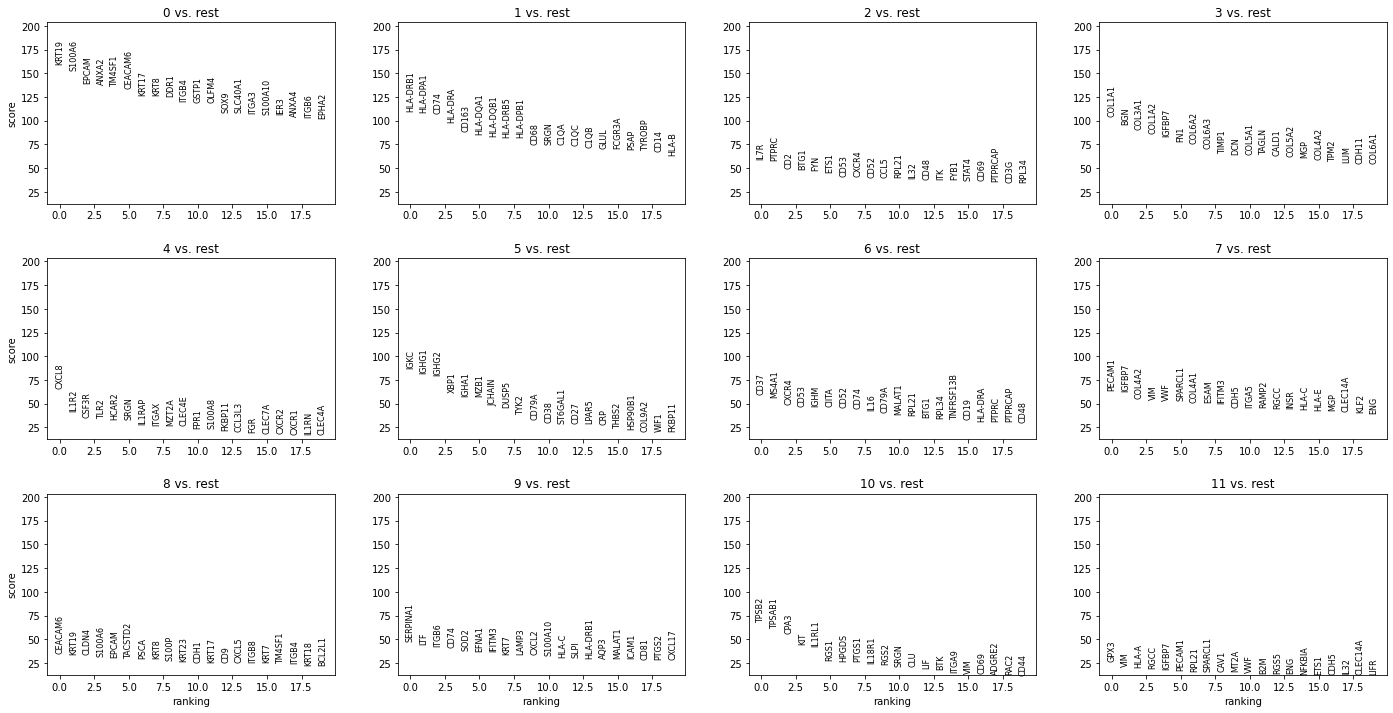

In [11]:
sc.pl.rank_genes_groups(adata)

## Plot the image with the Leiden subgroups

Plot the image, with an overlay of the expressed genes which were colored in consonance with the Leiden clustered subgroups. Use [`scanpy.pl.spatial`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.spatial.html) for the same.

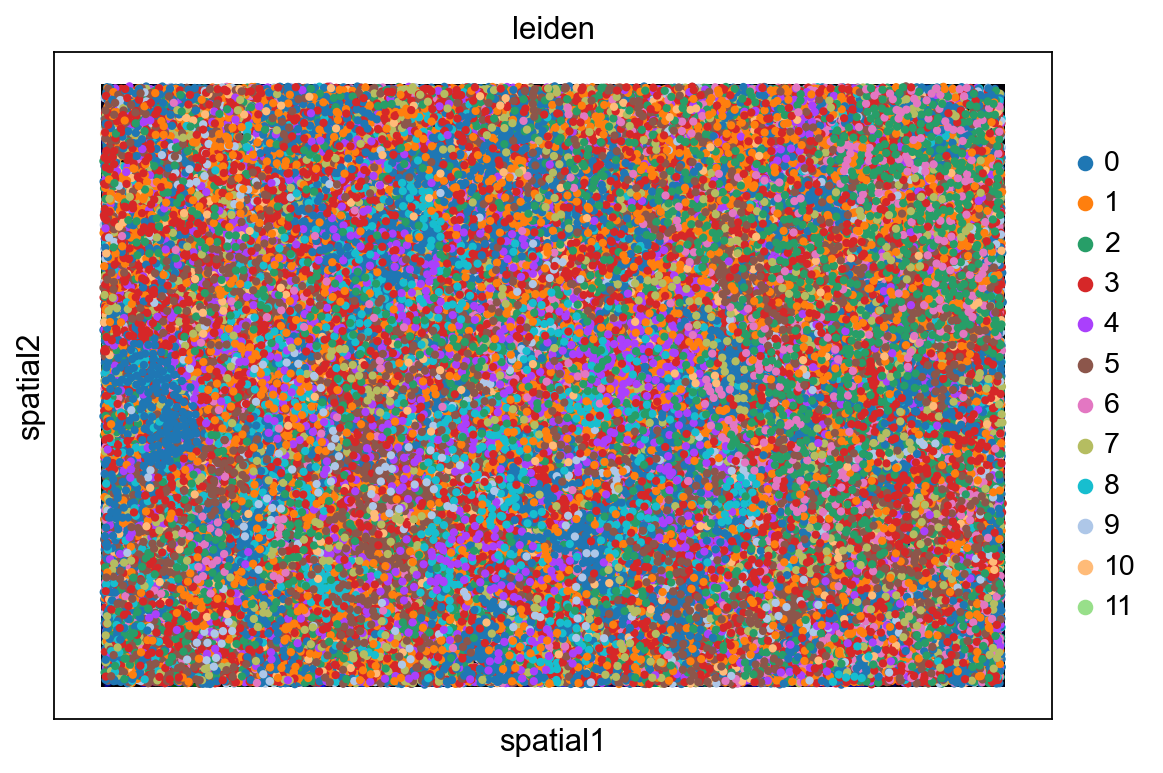

In [12]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color="leiden", library_id="16", spot_size=50)

One or multiple groups can also be used to overlay, by specifying the `groups` argument in [`scanpy.pl.spatial`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.spatial.html). The Leiden clusters can also be annotated by replacing the default numbers, according to the data as shown [here](https://github.com/theislab/squidpy_reproducibility/blob/master/notebooks/prepare_data/visium_hne.ipynb).

/opt/homebrew/Caskroom/miniforge/base/envs/squidpy_3_9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


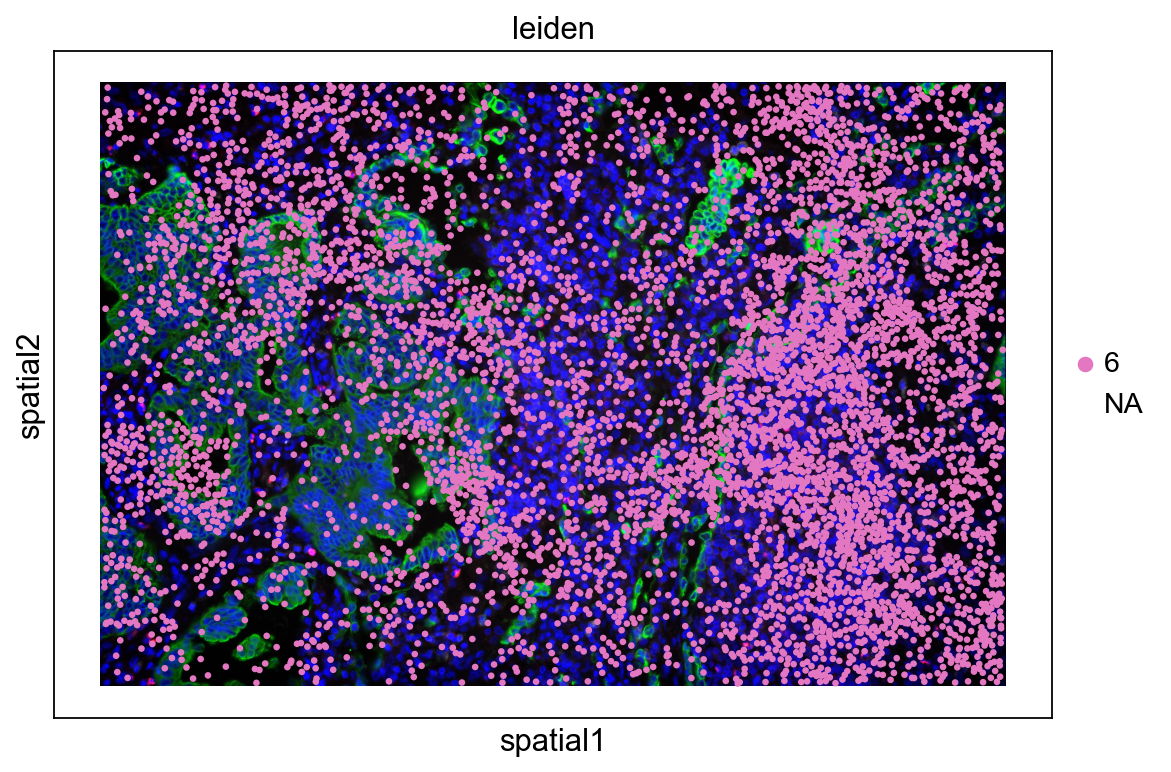

In [14]:
sc.pl.spatial(
    adata,
    color="leiden",
    groups=[
        "6",
    ],
    library_id="16",
    size=40,
)

## Write the anndata object to a file

In [23]:
adata.write("./tutorial_data/nanostring_data/Nanostring_Lung5Rep2_adata.h5ad")

## Check the file written

In [24]:
adata = sc.read("./tutorial_data/nanostring_data/Nanostring_Lung5Rep2_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 89246 × 980
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'fov_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'

----

# Compute centrality scores

This example shows how to compute centrality scores, given a spatial graph and cell type annotation.

The scores calculated are closeness centrality, degree centrality and clustering coefficient with the following properties:
* closeness centrality - measure of how close the group is to other nodes.
* clustering coefficient - measure of the degree to which nodes cluster together.
* degree centrality - fraction of non-group members connected to group members.

All scores are descriptive statistics of the spatial graph.

In [23]:
adata = sc.read("./tutorial_data/nanostring_data/Nanostring_Lung5Rep2_adata.h5ad")
adata

This dataset contains Leiden cluster groups' annotations in [`anndata.AnnData.obs`](https://anndata.readthedocs.io/en/refpaths/anndata.AnnData.obs.html#anndata.AnnData.obs), which are used for calculation of centrality scores.

First, we need to compute a connectivity matrix from spatial coordinates to calculate the centrality scores. We can use [`squidpy.gr.spatial_neighbors`](https://squidpy.readthedocs.io/en/latest/api/squidpy.gr.spatial_neighbors.html) for this purpose.

In [24]:
sq.gr.spatial_neighbors(adata)

Centrality scores are calculated with [`squidpy.gr.centrality_scores`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.centrality_scores.html#squidpy.gr.centrality_scores), with the Leiden groups as clusters.

In [26]:
sq.gr.centrality_scores(adata, cluster_key="leiden")

The results were visualized by plotting the average centrality, closeness centrality, and degree centrality using [`squidpy.pl.centrality_scores`](https://squidpy.readthedocs.io/en/stable/api/squidpy.pl.centrality_scores.html#squidpy.pl.centrality_scores).

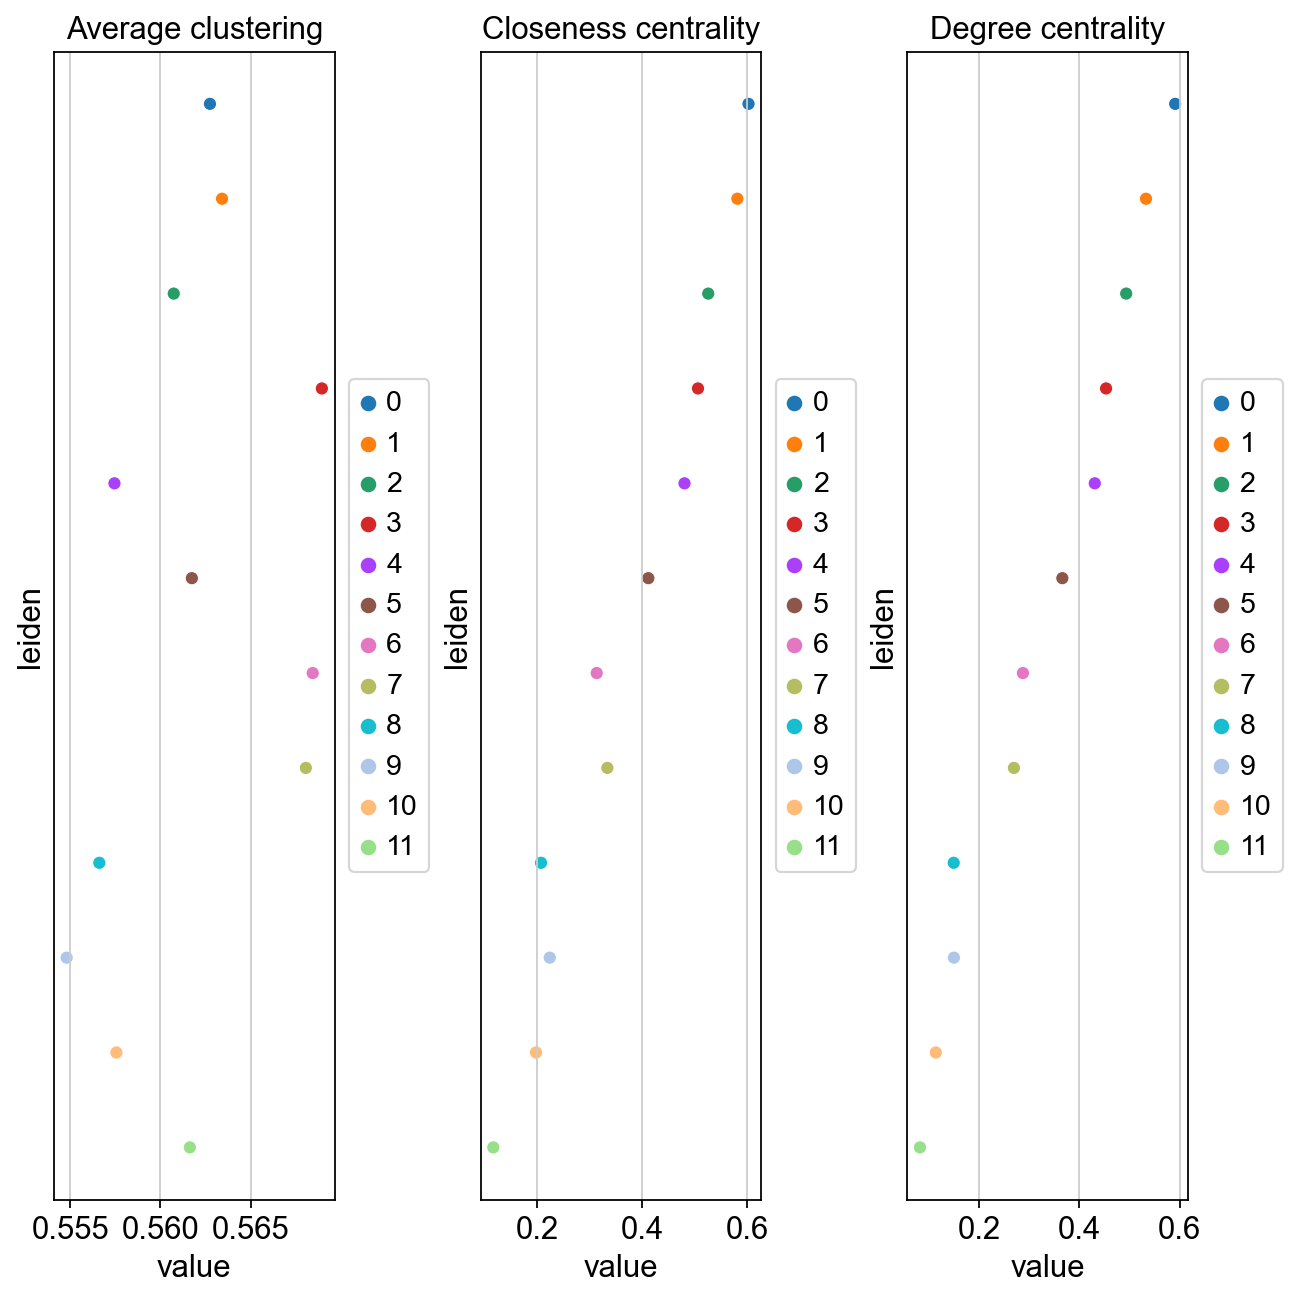

In [27]:
sq.pl.centrality_scores(adata, cluster_key="leiden")

----

# Compute co-occurrence probability

This example shows how to compute the co-occurrence probability.

The co-occurrence score is defined as:

$$\frac{p(exp|cond)}{p(exp)}$$
where $p(exp|cond)$ is the conditional probability of observing a
cluster $exp$ conditioned on the presence of a cluster $cond$, whereas
$p(exp)$ is the probability of observing $exp$ in the radius size of
interest. The score is computed across increasing radii size around each
cell in the tissue.

In [48]:
adata = sc.read("./tutorial_data/nanostring_data/Nanostring_Lung5Rep2_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 89246 × 980
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'fov_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'

We can compute the co-occurrence score with [`squidpy.gr.co_occurrence`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.co_occurrence.html#squidpy.gr.co_occurrence).
Results of co-occurrence probability ratio can be visualized with [`squidpy.pl.co_occurrence`](https://squidpy.readthedocs.io/en/stable/api/squidpy.pl.co_occurrence.html#squidpy.pl.co_occurrence). The '3' in the $\frac{p(exp|cond)}{p(exp)}$ represents a Leiden clustered group.

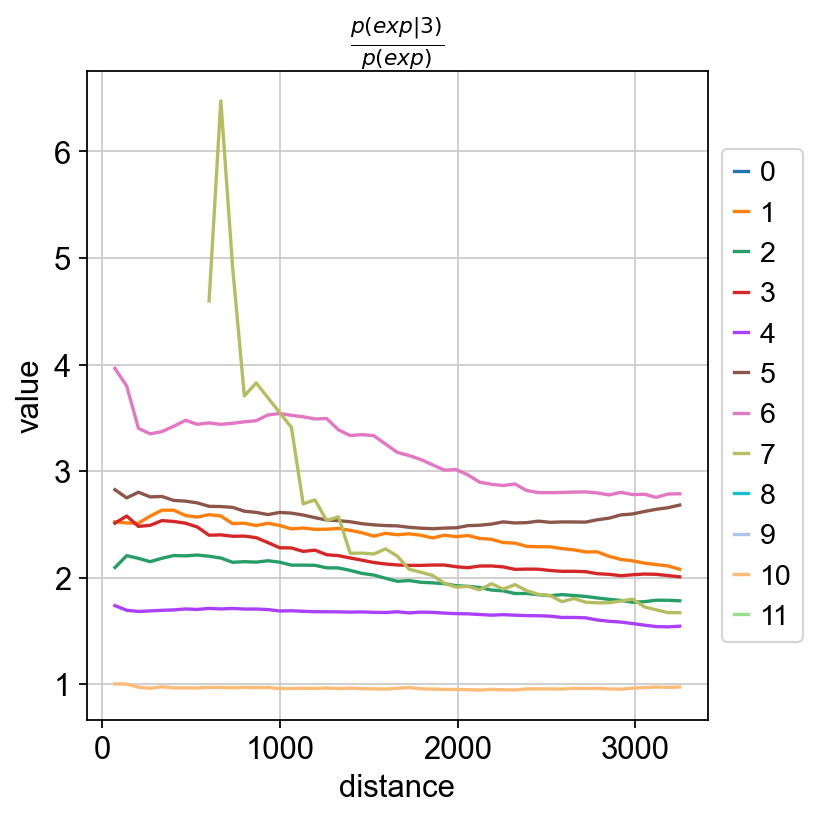

In [51]:
sq.gr.co_occurrence(
    adata,
    cluster_key="leiden",
)
sq.pl.co_occurrence(adata, cluster_key="leiden", clusters="3")

We can further visualize tissue organization in spatial coordinates with [`scanpy.pl.spatial`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.spatial.html#scanpy.pl.spatial), with an overlay of the expressed genes which were colored in consonance with the Leiden clustered subgroups.

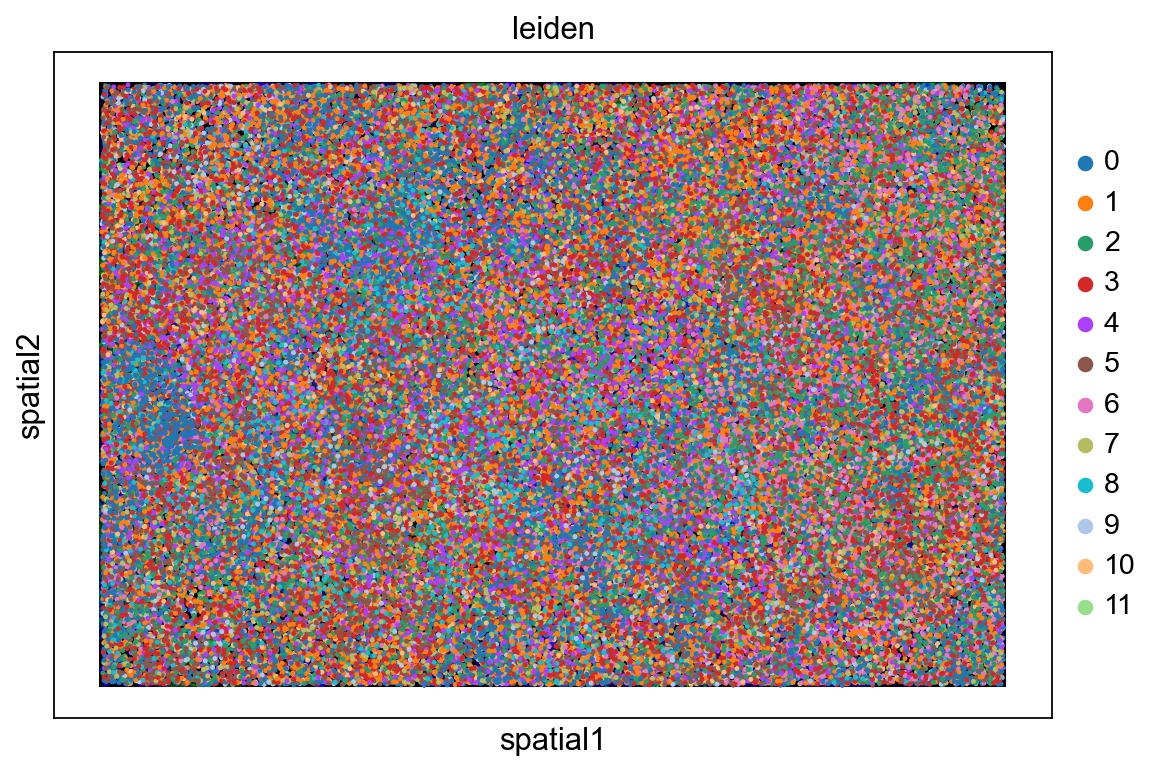

In [47]:
sc.pl.spatial(adata, library_id="16", color="leiden", spot_size=30)

----

# Compute interaction matrix

This example shows how to compute the interaction matrix.

The interaction matrix quantifies the number of edges that nodes belonging to a given annotation shares with the other annotations. It's a descriptive statistics of the spatial graph.

In [ ]:
adata = sc.read("./tutorial_data/nanostring_data/Nanostring_Lung5Rep2_adata.h5ad")
adata

First, we need to compute a connectivity matrix from spatial coordinates. We can use [`squidpy.gr.spatial_neighbors`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.spatial_neighbors.html#squidpy.gr.spatial_neighbors) for this purpose.

In [40]:
sq.gr.spatial_neighbors(adata)

We can compute the interaction matrix with [`squidpy.gr.interaction_matrix`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.interaction_matrix.html#squidpy.gr.interaction_matrix). `normalized = True` can be specified for a row-normalized matrix. Results are visualized with [`squidpy.pl.interaction_matrix`](https://squidpy.readthedocs.io/en/stable/api/squidpy.pl.interaction_matrix.html#squidpy.pl.interaction_matrix).

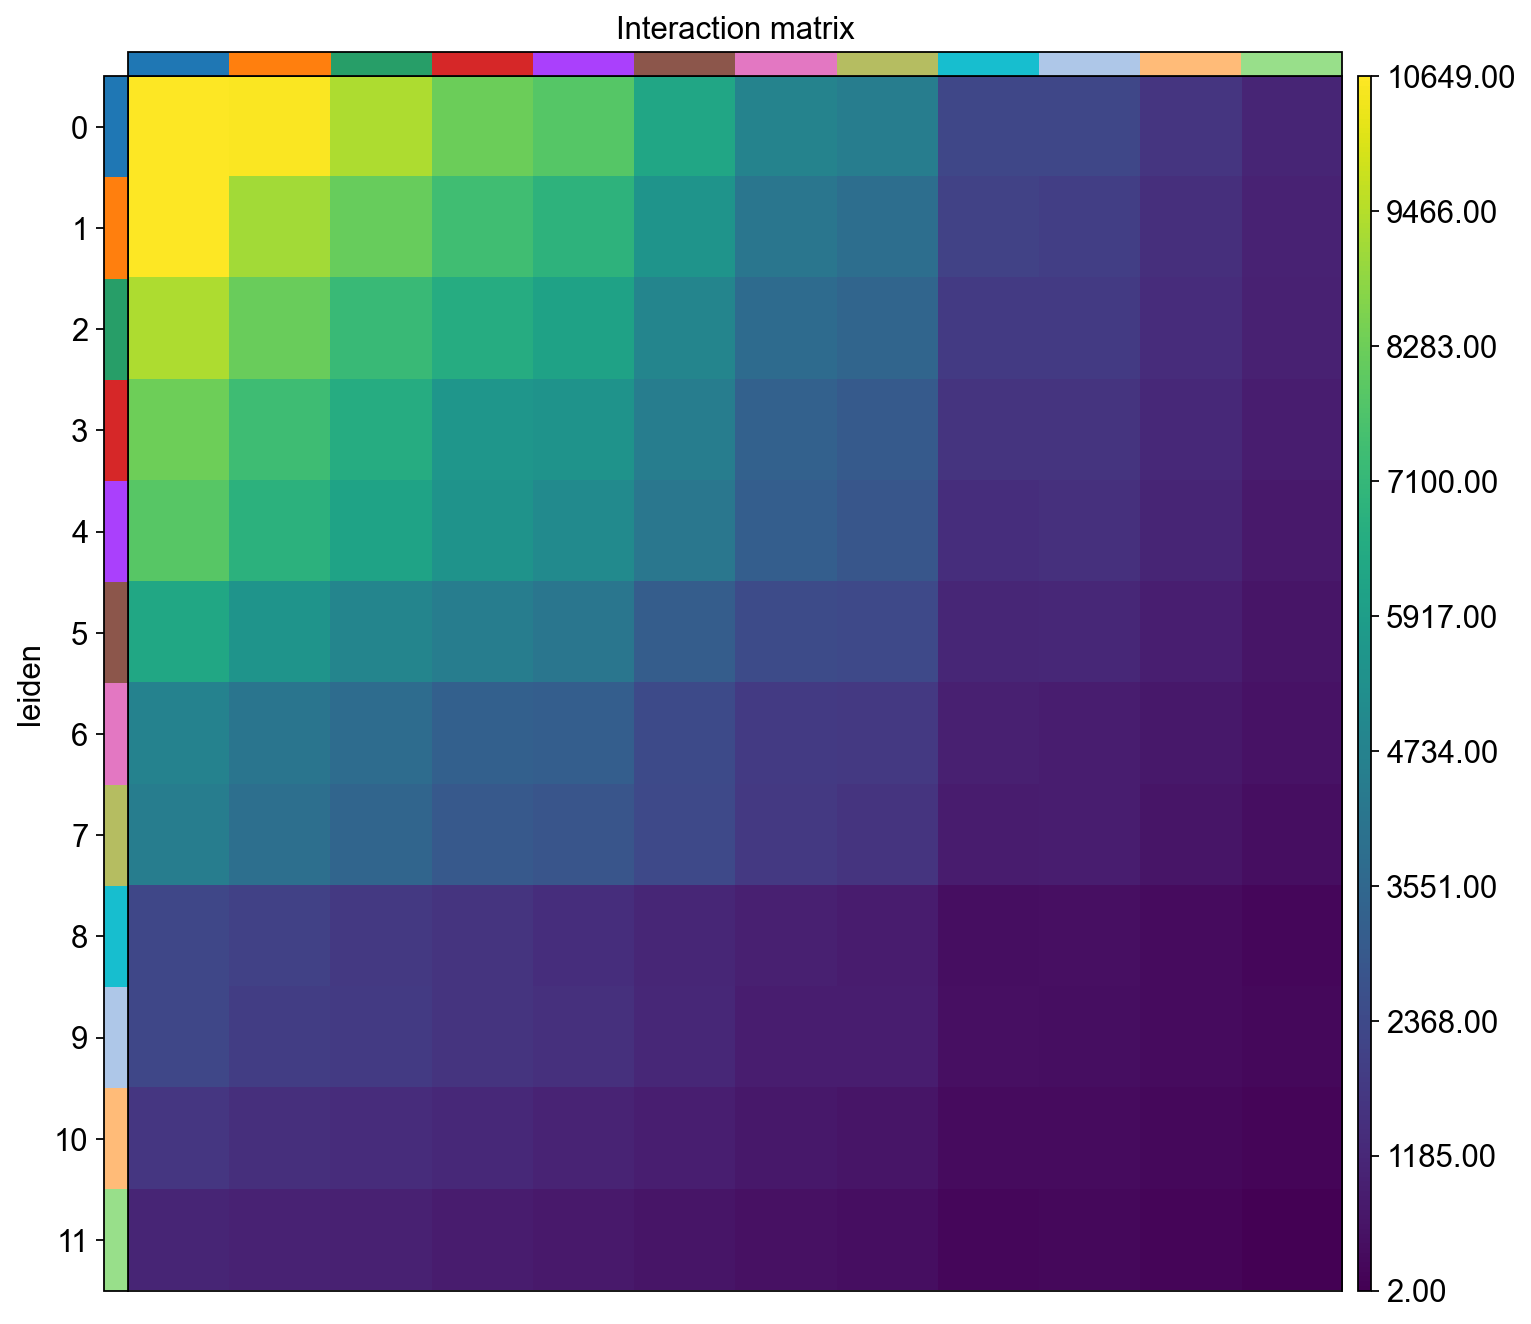

In [41]:
sq.gr.interaction_matrix(adata, cluster_key="leiden")
sq.pl.interaction_matrix(adata, cluster_key="leiden")

----

# Neighbors enrichment analysis

This example shows how to run the neighbors enrichment analysis routine.

It calculates an enrichment score based on proximity on the connectivity graph of cell clusters. The number of observed events is compared against $N$ permutations and a *z-score* is computed.


In [81]:
adata = sc.read("./tutorial_data/nanostring_data/Nanostring_Lung5Rep2_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 89246 × 980
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'fov_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'

This dataset contains cell type annotations in [`anndata.Anndata.obs`](https://anndata.readthedocs.io/en/refpaths/anndata.AnnData.obs.html) which are used for calculation of the neighborhood enrichment. First, we need to compute a connectivity matrix from spatial coordinates.

In [82]:
sq.gr.spatial_neighbors(adata)

Then we calculate the neighborhood enrichment score with [`squidpy.gr.nhood_enrichment`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.nhood_enrichment.html#squidpy.gr.nhood_enrichment).

In [83]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")




































































100%|██████████| 1000/1000 [00:11<00:00, 85.43/s]


And visualize the results with [`squidpy.pl.nhood_enrichment`](https://squidpy.readthedocs.io/en/stable/api/squidpy.pl.nhood_enrichment.html#squidpy.pl.nhood_enrichment).

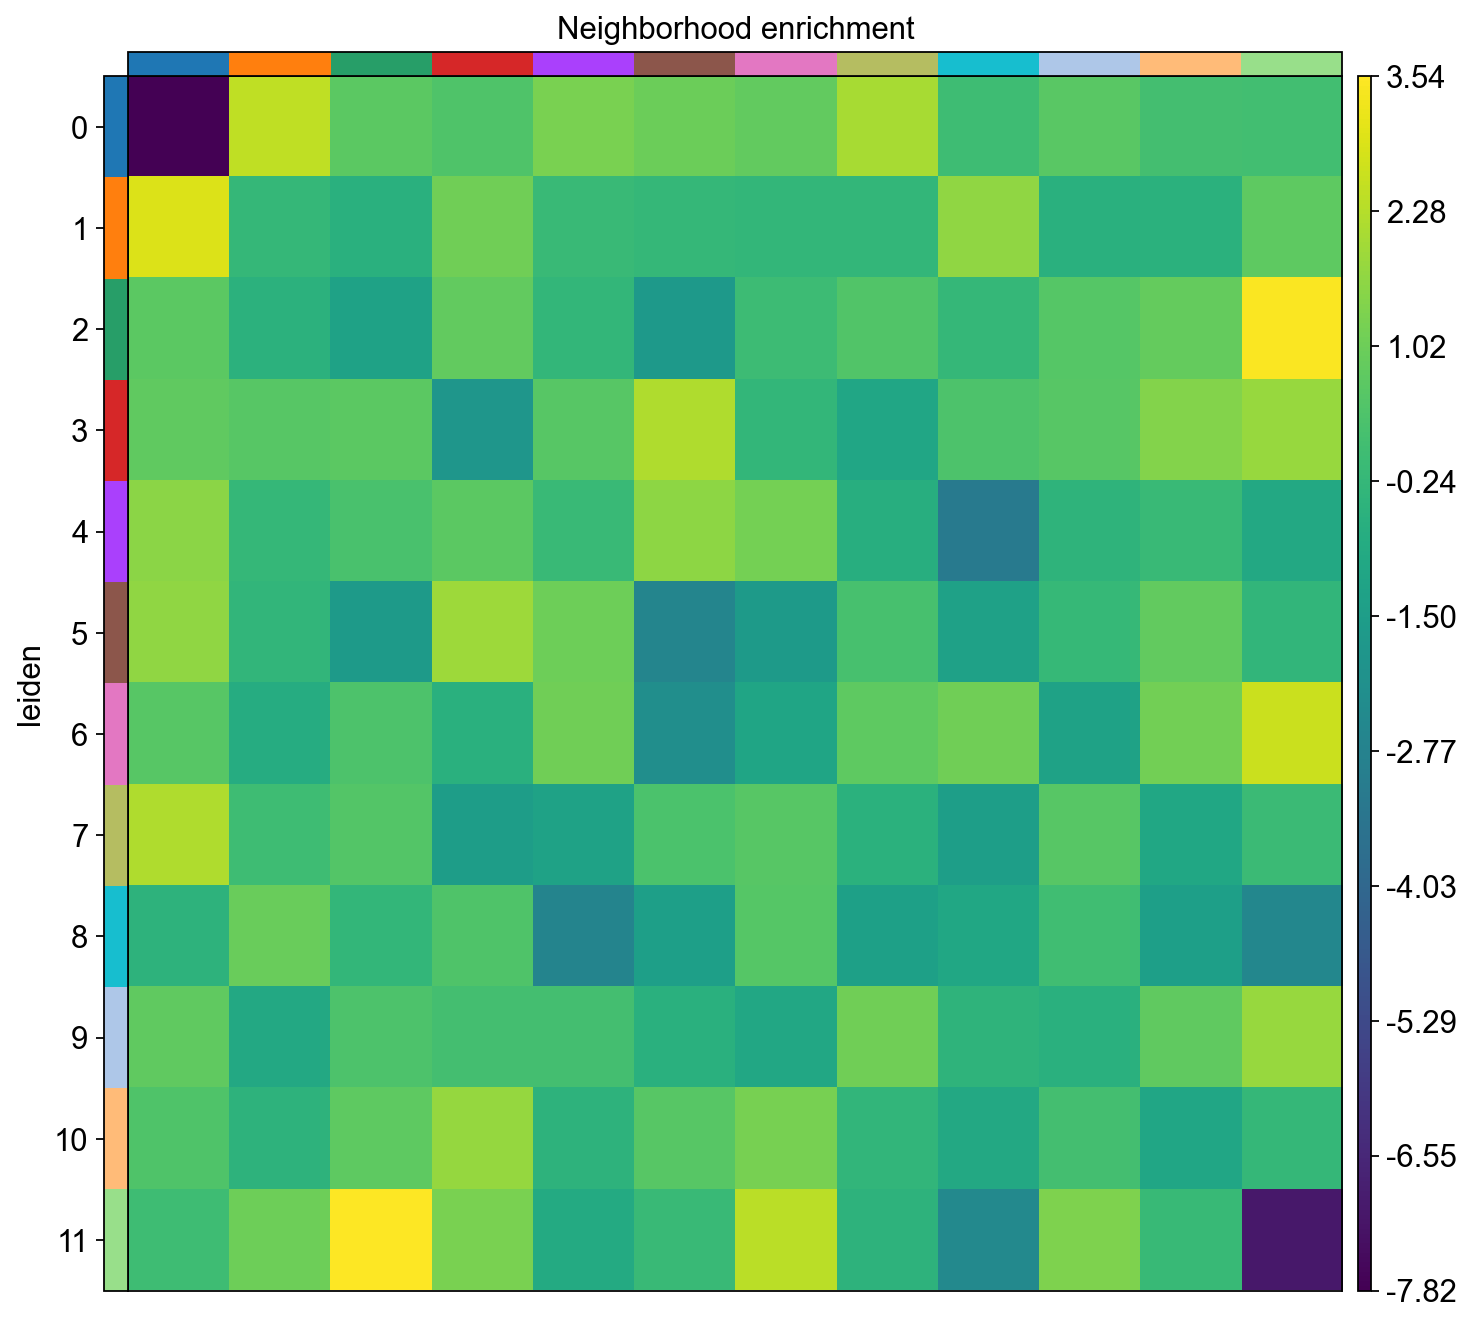

In [84]:
sq.pl.nhood_enrichment(adata, cluster_key="leiden")

----

# Compute Ripley's statistics

This example shows how to compute the Ripley's L function.

The Ripley's L function is a descriptive statistics generally used to determine whether points have a random, dispersed or clustered distribution pattern at certain scale. The Ripley's L is a variance-normalized version of the Ripley's K statistic.

In [76]:
adata = sc.read("./tutorial_data/nanostring_data/Nanostring_Lung5Rep2_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 89246 × 980
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'fov_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'

We can compute the Ripley's L function with [`squidpy.gr.ripley`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.ripley.html#squidpy.gr.ripley).
Results can be visualized with [`squidpy.pl.ripley`](https://squidpy.readthedocs.io/en/stable/api/squidpy.pl.ripley.html#squidpy.pl.ripley).

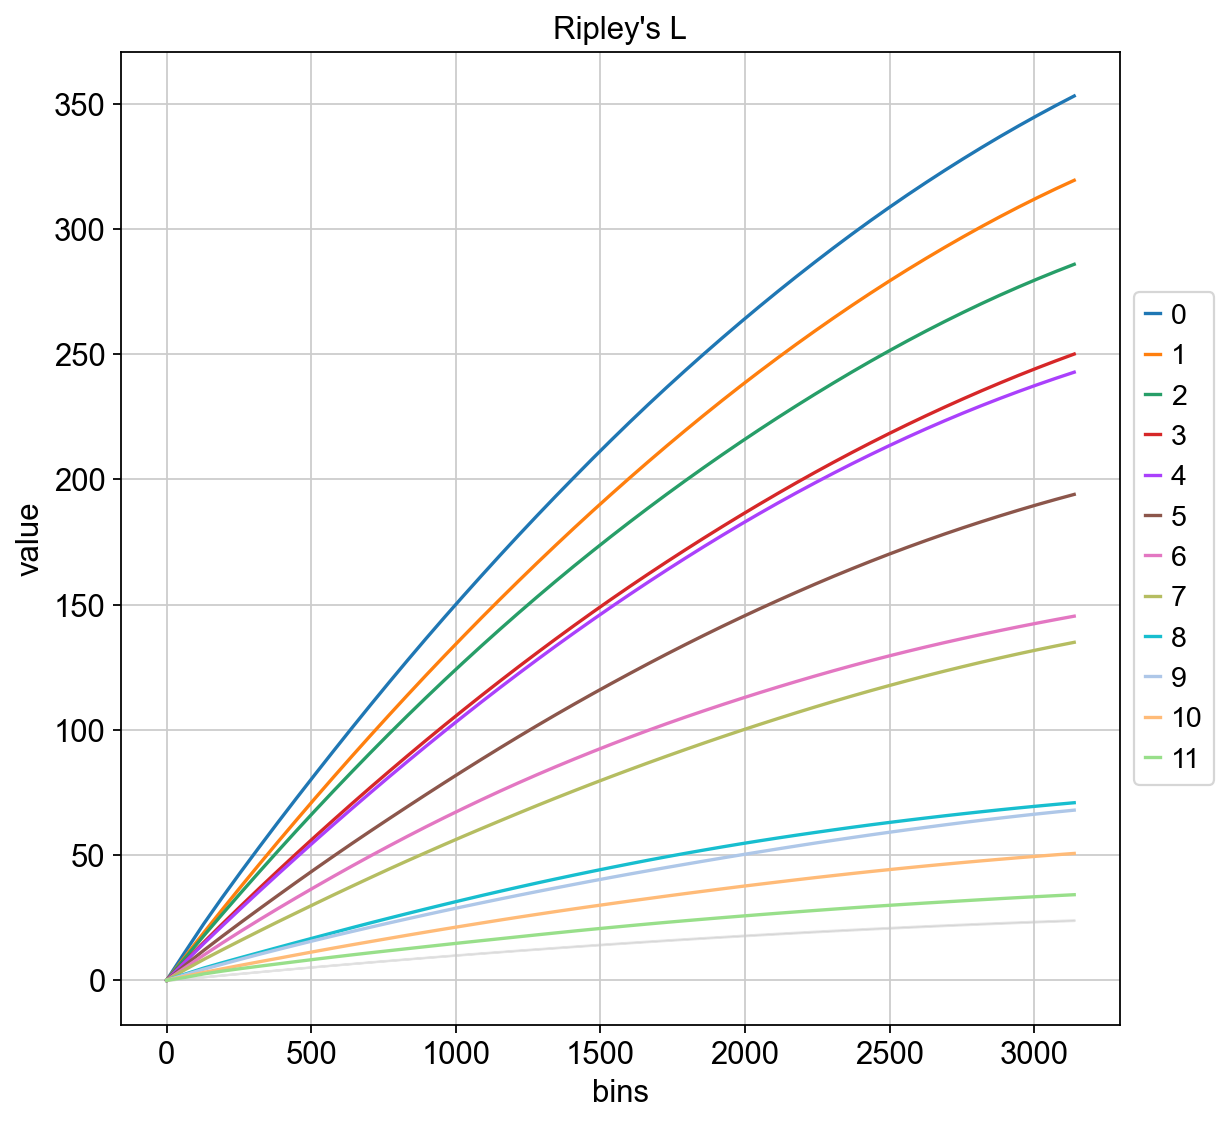

In [77]:
mode = "L"
sq.gr.ripley(adata, cluster_key="leiden", mode=mode)
sq.pl.ripley(adata, cluster_key="leiden", mode=mode)

We can further visualize tissue organization in spatial coordinates with [`scanpy.pl.spatial`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.spatial.html#scanpy.pl.spatial).

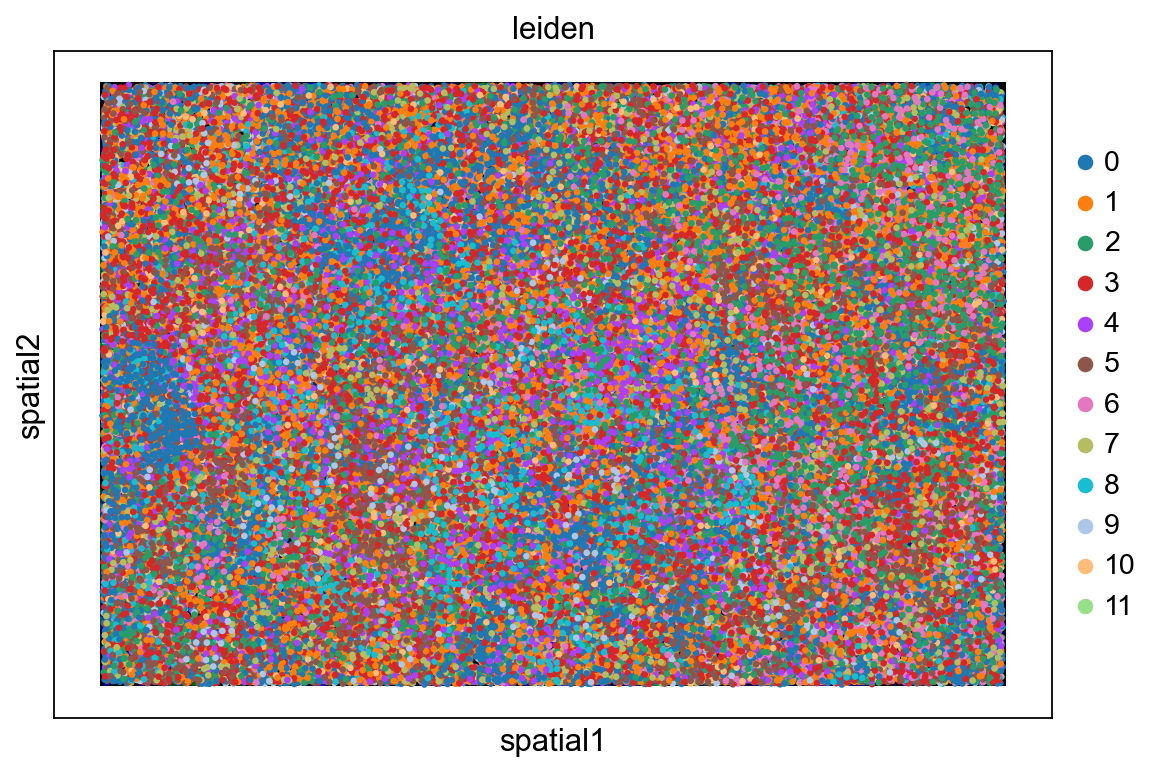

In [80]:
sc.pl.spatial(adata, library_id="16", color="leiden", spot_size=40)

There are also 2 other Ripley\'s statistics available (that are closely related): `mode = 'F'` and `mode = 'G'`.

----

# Building the spatial neighbors graphs

Spatial graph is a graph of spatial neighbors with observations as nodes and neighbor-hood relations between observations as edges. We use spatial coordinates of spots/cells to identify neighbors among them. Different approach of defining a neighborhood relation among observations are used for different types of spatial datasets.

In [85]:
adata = sc.read("./tutorial_data/nanostring_data/Nanostring_Lung5Rep2_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 89246 × 980
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'fov_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'

We use [`squidpy.gr.spatial_neighbors`](https://squidpy.readthedocs.io/en/latest/api/squidpy.gr.spatial_neighbors.html#squidpy.gr.spatial_neighbors) for this. The function expects `coord_type = 'visium'` by default. We set this parameter here explicitly for clarity. `n_rings` should be used only for Visium datasets. It specifies for each spot how many hexagonal rings of spots around will be considered neighbors.

In [86]:
sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)

The function builds a spatial graph and saves its adjacency matrix to `adata.obsp['spatial_connectivities']` and weighted adjacency matrix to `adata.obsp['spatial_distances']` by default. Note that it can also build a graph from a square grid, just set `n_neighs = 4`.

In [89]:
adata.obsp["spatial_connectivities"]

<89246x89246 sparse matrix of type '<class 'numpy.float64'>'
	with 417989 stored elements in Compressed Sparse Row format>

The weights of the weighted adjacency matrix are ordinal numbers of
hexagonal rings in the case of `coord_type = 'visium'`.

In [91]:
adata.obsp["spatial_distances"]

<89246x89246 sparse matrix of type '<class 'numpy.float64'>'
	with 417989 stored elements in Compressed Sparse Row format>

We can visualize the neighbors of a point to better visualize what *n_rings* mean:

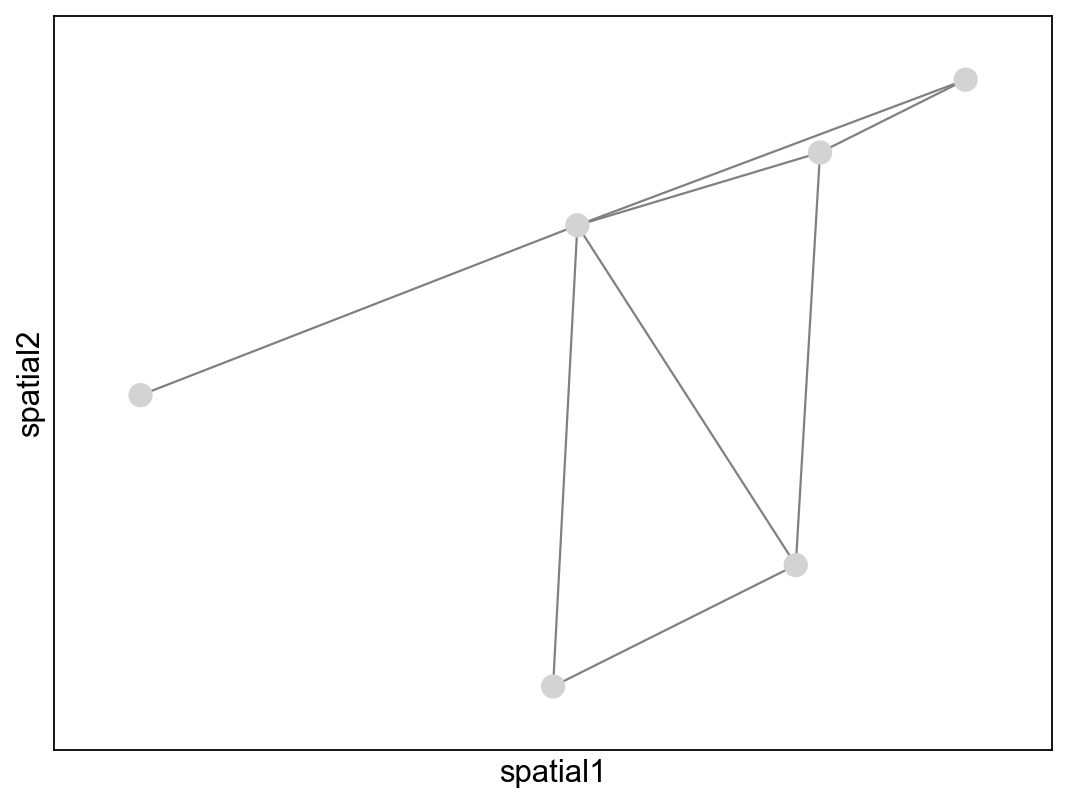

In [95]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sc.pl.spatial(
    adata[idx, :],
    library_id="16",
    neighbors_key="spatial_neighbors",
    edges=True,
    edges_width=1,
    img_key=None,
)

Next, we show how to compute the spatial neighbors graph for a non-grid dataset.

In [96]:
adata = sc.read("./tutorial_data/nanostring_data/Nanostring_Lung5Rep2_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 89246 × 980
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'fov_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'

We use the same function for this with `coord_type = 'generic'`. `n_neighs` and `radius` can be used for non-Visium datasets. `n_neighs` specifies a fixed number of the closest spots for each spot as neighbors. Alternatively, `delaunay = True` can be used, for a Delaunay triangulation graph.

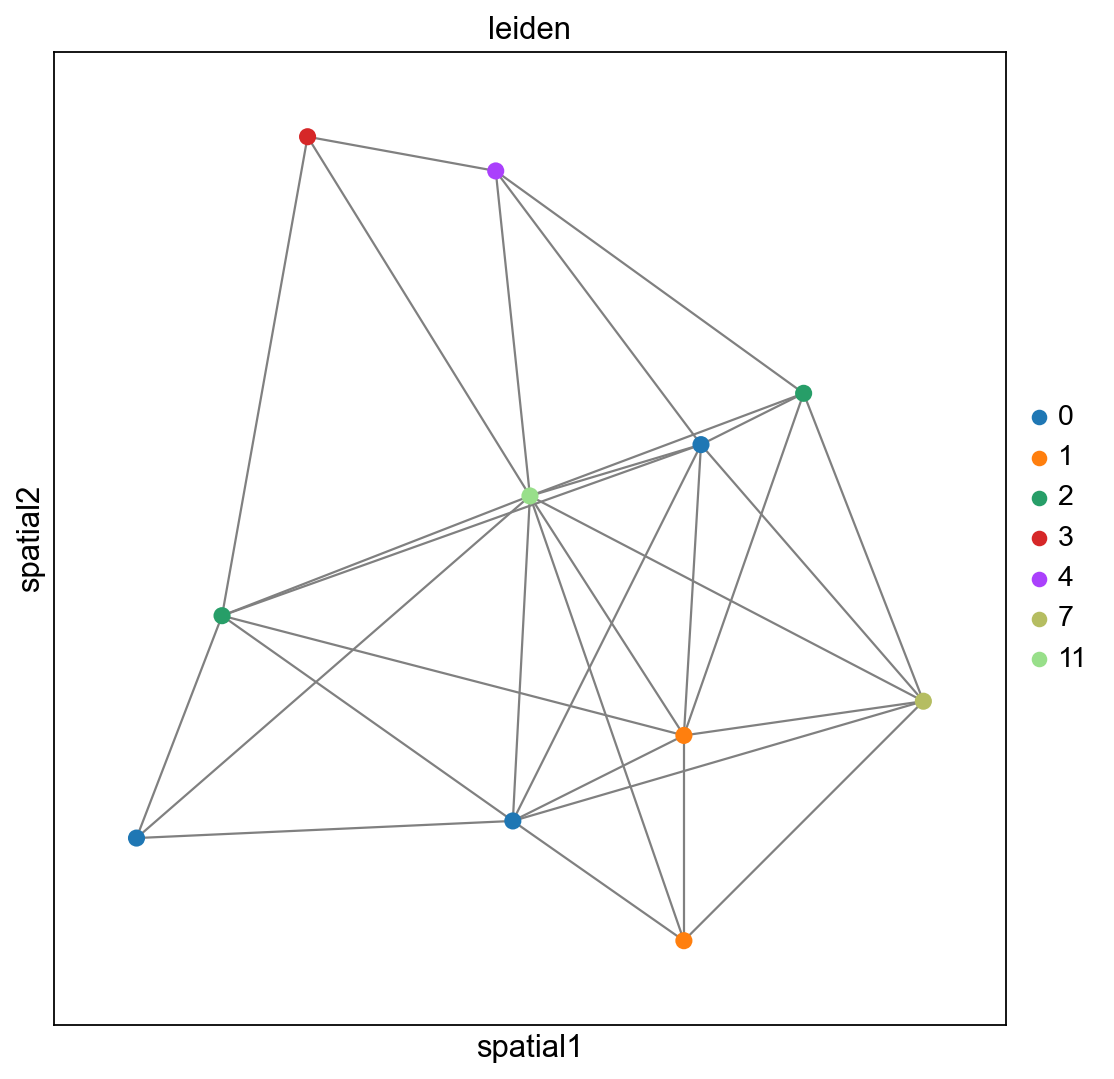

In [98]:
sq.gr.spatial_neighbors(adata, n_neighs=10, coord_type="generic")
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sc.pl.spatial(
    adata[idx, :],
    library_id="16",
    color="leiden",
    neighbors_key="spatial_neighbors",
    spot_size=1,
    edges=True,
    edges_width=1,
    img_key=None,
)

We use the same function for this with `coord_type = 'generic'` and `delaunay = True`. You can appreciate that the neighbor graph is different than before.


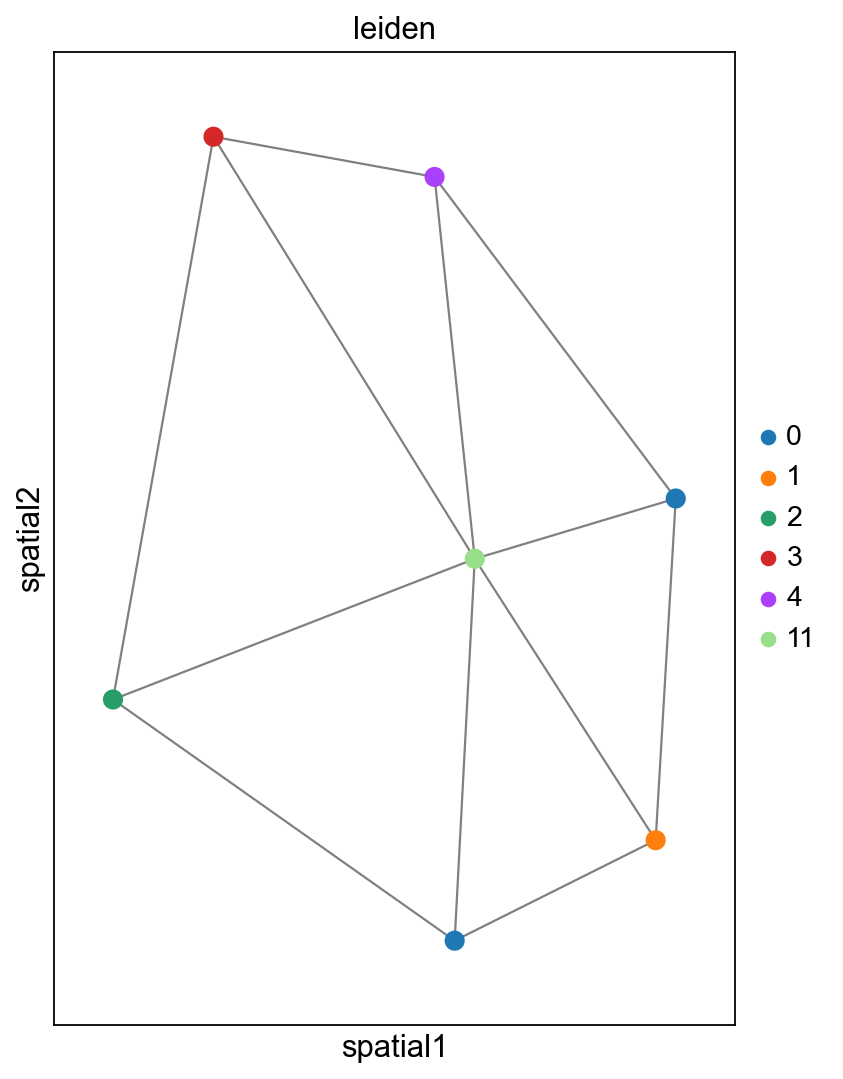

In [99]:
sq.gr.spatial_neighbors(adata, delaunay=True, coord_type="generic")
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sc.pl.spatial(
    adata[idx, :],
    library_id="16",
    color="leiden",
    neighbors_key="spatial_neighbors",
    spot_size=1,
    edges=True,
    edges_width=1,
    img_key=None,
)

In order to get all spots within a specified radius (in units of the spatial coordinates) from each spot as neighbors, the parameter `radius` should be used.

In [100]:
sq.gr.spatial_neighbors(adata, radius=0.3, coord_type="generic")

adata.obsp["spatial_connectivities"]
adata.obsp["spatial_distances"]

<89246x89246 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>